# Blood Glucose Control - EDA

**Name:** Abdullah Shahid



### Import Data

There are multiple data sets each corresponding to a person with diabetes. Please load the files into a single data set while retaining the ability to distinguish between the PWD. 

In [111]:
import pandas as pd
import matplotlib.pyplot as plt

df1_raw = pd.read_csv('../data/gluroo_500030.csv')
df2_raw = pd.read_csv('../data/gluroo_679372.csv')

df1 = df1_raw.drop(columns=['sender_id'])
df2 = df2_raw.drop(columns=['sender_id'])
df2 = df2.drop(df2.index[0:5])

# Using my own id just so it's a little easier to read
df1['person_id'] = '1'
df2['person_id'] = '2'

df = pd.concat([df1, df2])

pd.set_option('display.max_rows', 5)
# pd.set_option('display.max_colwidth', None)
df[df['affects_iob'] == True]

,date,bgl,bgl_date_millis,text,template,msg_type,affects_fob,affects_iob,dose_units,food_g,food_glycemic_index,dose_automatic,fp_bgl,message_basal_change,__typename,trend,person_id
118,2024-05-01 09:46:39.884000-05:00,101.0,1.714575e+12,Dosed 4u,NaN,DOSE_INSULIN,False,True,4.0,NaN,NaN,False,NaN,NaN,Message,NaN,1
138,2024-05-01 11:18:11.771000-05:00,115.0,1.714580e+12,Dosed 9u,NaN,DOSE_INSULIN,False,True,9.0,NaN,NaN,False,NaN,NaN,Message,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32065,2024-07-31 18:37:59.663000-04:00,119.0,1.722465e+12,Dosed 2u,NaN,DOSE_INSULIN,False,True,2.0,NaN,NaN,False,NaN,NaN,Message,NaN,2
32160,2024-07-31 23:19:10.806000-04:00,209.0,1.722482e+12,Dosed 1u,NaN,DOSE_INSULIN,False,True,1.0,NaN,NaN,False,NaN,NaN,Message,NaN,2


### Two Data Visualizations

Create at least two visualizations that are of interest to you. They can be things that would be useful information for a PWD to know, or they could be useful for informing future modeling work. If you aren't sure what to visualize try recreating common diabetes data visualizations that you can find on the internet. 

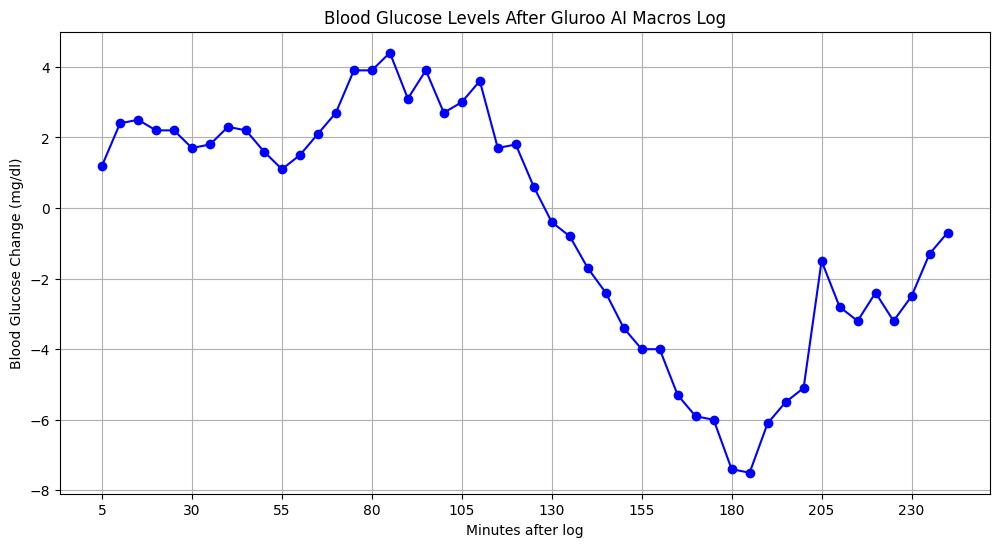

In [74]:
indices = df.index[(df['template'] == 'GLUROOAI_RESPONSE_FN_log_that') & (df['bgl'].notna())].tolist()
count = len(indices)

bgl_sums = [0]*48

for idx in indices:
    step = 0
    while step < 48:
        step += 1
        if idx + step >= len(df):
            break
        bgl_sums[step - 1] += df.iloc[idx + step]['bgl'] - df.iloc[idx]['bgl']

bgl_avgs = [bg_sum / count for bg_sum in bgl_sums]

bgl_df = pd.DataFrame(bgl_avgs, columns=['bgl'])

plt.figure(figsize=(12, 6))
plt.plot(bgl_df['bgl'].reset_index(drop=True), marker='o', linestyle='-', color='b')
plt.title('Blood Glucose Levels After Gluroo AI Macros Log')
plt.xlabel('Minutes after log')
plt.xticks(range(0, 48, 5), [5 * i for i in range(1, 49, 5)]) 
plt.ylabel('Blood Glucose Change (mg/dl)')
plt.grid(True)
plt.show()

For the above graph, I tried seeing if logging a meal where the macros were predicted by thwe Gluroo AI had any affect on blood sugar afterwards. Initially I was looking up to 1-2 hours ahead but didn't find much of a correlation, but looking 4 hours ahead shows that blood sugar dips before correcting itself. Of course there isn't nearly enough data to draw conclusions (there were only 10 Gluroo AI logs), but there's still a significant dip after 2 hours that may be worth looking into in a larger dataset.

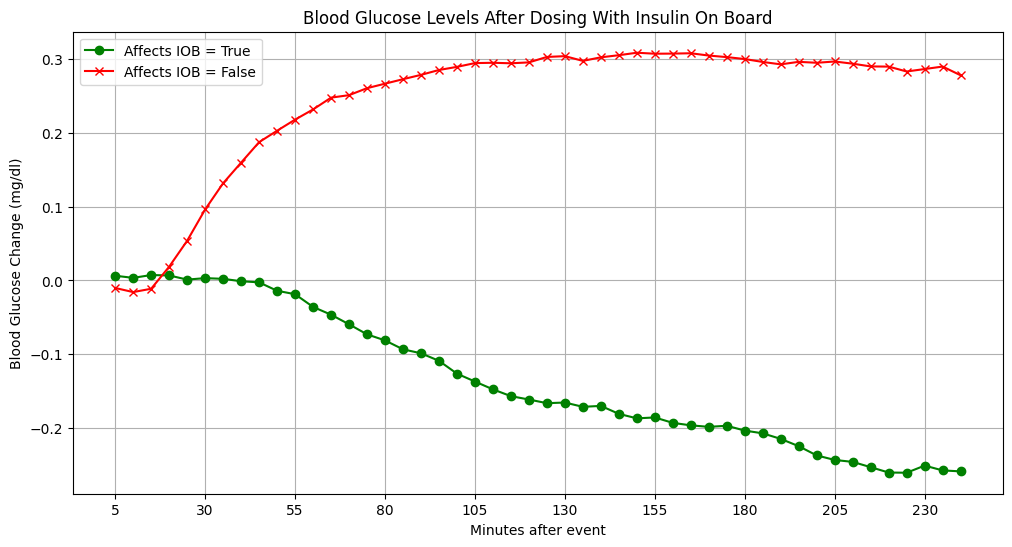

In [112]:
true_indices = df.index[(df['affects_iob'] == True) & (df['bgl'].notna())].tolist()
false_indices = df.index[(df['affects_iob'] == False) & (df['bgl'].notna())].tolist()

def get_bgl_trends(indices, steps=48):
    bgl_sums = [0] * steps
    count = 0
    
    for idx in indices:
        step = 0
        
        if pd.isna(df.iloc[idx]['bgl']):
            continue

        while step < steps:
            step += 1
            if idx + step >= len(df):
                break
            if pd.notna(df.iloc[idx + step]['bgl']):
                bgl_sums[step - 1] += df.iloc[idx + step]['bgl'] - df.iloc[idx]['bgl']
                count += 1

    bgl_avgs = [bg_sum / count if count > 0 else 0 for bg_sum in bgl_sums]
    return bgl_avgs

bgl_true_avgs = get_bgl_trends(true_indices)
bgl_false_avgs = get_bgl_trends(false_indices)

bgl_true_df = pd.DataFrame(bgl_true_avgs, columns=['bgl_true'])
bgl_false_df = pd.DataFrame(bgl_false_avgs, columns=['bgl_false'])

plt.figure(figsize=(12, 6))
plt.plot(bgl_true_df['bgl_true'].reset_index(drop=True), marker='o', linestyle='-', color='g', label='Insulin On Board')
plt.plot(bgl_false_df['bgl_false'].reset_index(drop=True), marker='x', linestyle='-', color='r', label='No Insulin On Board')
plt.title('Blood Glucose Levels After Dosing')
plt.xlabel('Minutes after event')
plt.xticks(range(0, 48, 5), [5 * i for i in range(1, 49, 5)])
plt.ylabel('Blood Glucose Change (mg/dl)')
plt.grid(True)
plt.legend()
plt.show()

This one was pretty obvious - dosing while insulin is on board will usually lead to a drop in blood sugar. Even though the difference in bloog sugar isn't large, the difference in trends is still very significant and is important for a non-diabetic to understand.

I wanted to go just a little deeper than this and see if the time of day had any affect on these relationships, as in my personal experience, my insulin sensitivity usually varies throughout the day (especially in the morning).

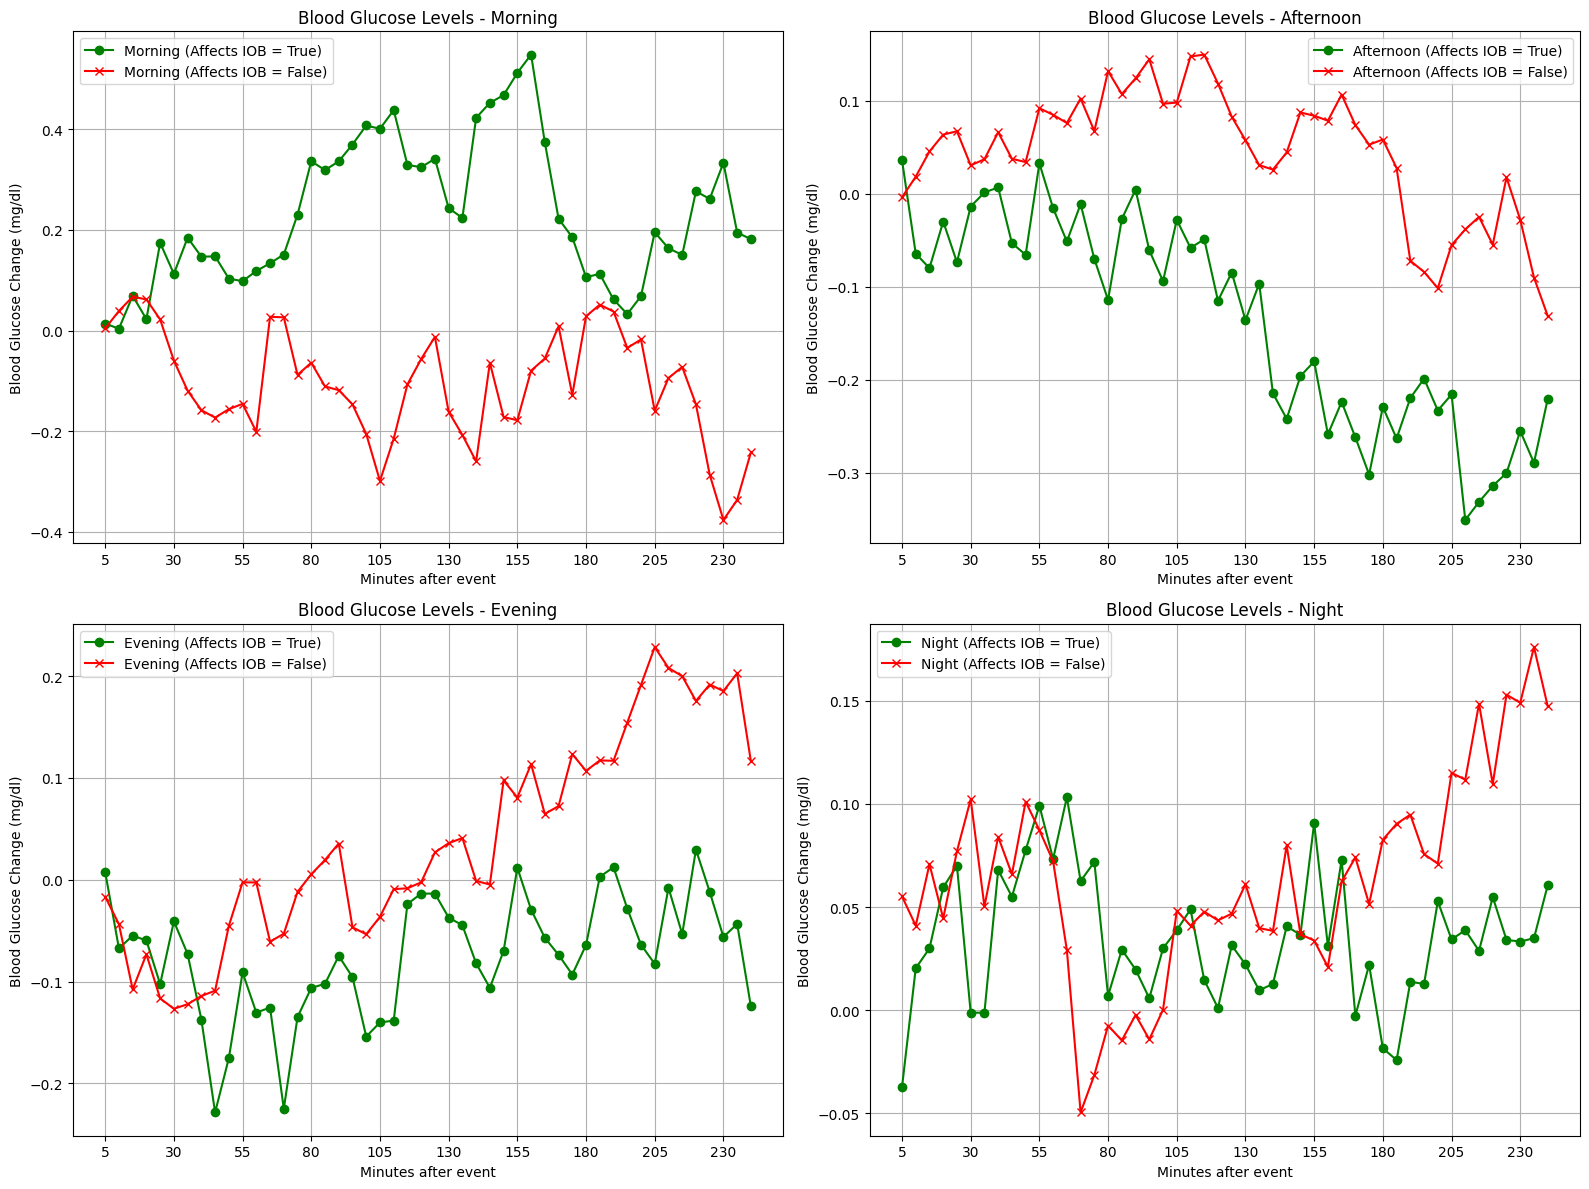

In [142]:
import matplotlib.pyplot as plt
import pandas as pd

df['date'] = pd.to_datetime(df['date'])

def get_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

df['time_of_day'] = df['date'].dt.hour.apply(get_time_of_day)

def get_bgl_trends(indices, steps=48):
    bgl_sums = [0]*steps
    count = 0
    
    for idx in indices:
        step = 0
        
        while step < steps:
            step += 1
            if idx + step >= len(df):
                break
            
            if pd.isna(df.iloc[idx]['bgl']) or pd.isna(df.iloc[idx + step]['bgl']):
                continue
            
            bgl_sums[step - 1] += df.iloc[idx + step]['bgl'] - df.iloc[idx]['bgl']
            count += 1

    bgl_avgs = [bg_sum / count if count > 0 else 0 for bg_sum in bgl_sums]
    
    return bgl_avgs


def analyze_time_of_day(time_period):
    true_indices = df.index[(df['affects_iob'] == True) & (df['time_of_day'] == time_period) & (df['bgl'].notna())].tolist()
    false_indices = df.index[(df['affects_iob'] == False) & (df['time_of_day'] == time_period) & (df['bgl'].notna())].tolist()
    
    bgl_true_avgs = get_bgl_trends(true_indices)
    bgl_false_avgs = get_bgl_trends(false_indices)
    
    return bgl_true_avgs, bgl_false_avgs

time_periods = ['Morning', 'Afternoon', 'Evening', 'Night']

plt.figure(figsize=(16, 12))

for i, time_period in enumerate(time_periods):
    plt.subplot(2, 2, i+1)
    
    bgl_true_avgs, bgl_false_avgs = analyze_time_of_day(time_period)
    
    plt.plot(bgl_true_avgs, marker='o', linestyle='-', color='g', label=f'{time_period} (Affects IOB = True)')
    plt.plot(bgl_false_avgs, marker='x', linestyle='-', color='r', label=f'{time_period} (Affects IOB = False)')
    
    plt.title(f'Blood Glucose Levels - {time_period}')
    plt.xlabel('Minutes after event')
    plt.xticks(range(0, 48, 5), [5 * i for i in range(1, 49, 5)])
    plt.ylabel('Blood Glucose Change (mg/dl)')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


**Morning**: I did expect that the morning trends would be different but I didn't expect it to be completely flipped, with the doses that affect IOB seeing a rise in bg and doses that don't seeing a drop. But around 3 hours after the dose, both doses that affect and don't affect IOB end up around the same point before diverging again. But knowing how some of my mornings are, it could be that on certain mornings, especially when the dawn phenomenon was more pronounced, the users may have double/triple dosed to counteract the rising blood sugar. Because of this, many of the doses flagged as affecting IOB might reflect cases where the user's blood sugar was already rising, skewing the data.

**Afternoon**: This is pretty predictable and straightforward. With the dawn phenomenon out of the way, afternoon blood sugars are more stable and insulin sensitivity is normal. The general trend is a steady decrease, possible after correcting morning highs.

**Evening**: Same thing here - doses that affect IOB see lower bg than doses that don't. The general trend here is a steady increase, possibly after a big yummy dinner.

**Night**: This one is a bit chaotic, it doesn't seem like doses that affect IOB increase or decrease bg much compared to doses that don't. There is a divergence after 3 hours, but we can't say for sure that this is because of the doses since they don't usually last that long.

### Ask a question(s) about the data and/or diabetes!
When creating the visualizations you probably had some questions about managing T1D. Ask some questions that might interest you and our diabetes experts will do their best to answer them for you! *Consider this an AMAA about diabetes.* 

1. What are some misconceptions about T1D that non-diabetics might have?
2. What are some daily challenges that you and other T1Ds face that isn't obvious to non-diabetics?

### Final Task

Thanks for showing interest in our project! We plan to incorporate the best/most interesting visualizations into a substack post in the future. 

Please remember to create a pull request with your updated template, don't forget to rename the file to something that we can identify you with, e.g: `eda_[your_name].ipynb`